# RA2CE feature: single link redundancy without the example data

This notebook contains an example of the **single link redundancy analysis** of the RA2CE tool. This notebook does not require the example data. However, it does require a network. If the user is not familiair with this, they should first go through the ra2ce_basics notebook and configure a network!

In this notebook, we will guide you through the single link redundancy analysis, which gives insight into network criticality.

First of all, we will import the packages we need to execute the notebook:

In [ ]:
import geopandas as gpd
from IPython.display import display
from pathlib import Path

Import the RA2CE Handler

In [ ]:
from ra2ce.ra2ce_handler import Ra2ceHandler # import the ra2cehandler to run ra2ce analyses

## Configuring RA2CE for a Single link redundancy analyis

Now, we will look into the analyses.ini.  The single link redundancy analysis gives insight into the criticality of (road) networks. This analysis removes each link of the network one at a time. For each disrupted link, a redundancy analysis is performed. It identifies the best existing alternative route or, if there is no redundancy, the lack of alternative routes. This is performed sequentially, for each link of the network. The redundancy of each link is expressed in total distance or time for the alternative route, difference in distance/time between the alternative route and the original route (additional distance/time), and if there is an alternative route available, or not

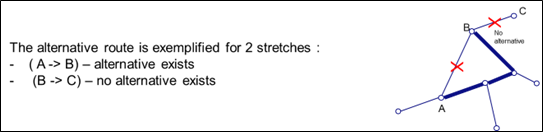

In this example, we perform a single link redundancy analysis for the network which we created in the **RA2CE Basics** example. The relevant function for this type of analysis is *single_link_redundancy*. Other types of losses analyses can be found [here](https://deltares.github.io/ra2ce/analysis_module/analysis_module.html#indirect-losses-network-criticality). You can set this in the analyses.ini which we will later use to call RA2CE. The redundancy of each link is expressed in the total distance (weighing) for the alternative route (weighing = distance).

Open your analysis.ini and specify the following parameters in the same way as below:

> [project] <br>
name = beira <br>
 <br>
[analysis1] <br>
name = beira_redundancy <br>
analysis = single_link_redundancy <br>
weighing = distance <br>
save_gpkg = True <br>
save_csv = True <br>

Then, we find the analyses.ini on our local machine. 

In [ ]:
root_dir = Path("data", "single_link_redun") # set path to your RA2CE folder which holds the input data and a pre-defined network

_network_ini_name = "network.ini" # set the name for the network.ini settings file
_analyses_ini_name = "analyses.ini" # set the name for the analysis.ini

network_ini = root_dir / _network_ini_name # set path to network.ini
analyses_ini = root_dir / _analyses_ini_name # set path to analysis.ini

assert network_ini.is_file() # check whether the network.ini file exists
assert analyses_ini.is_file() # check whether the analysis.ini file exists

## Running RA2CE
We configure and run the single link redundancy analysis with the following methods from the Ra2ceHandler class. We do not have to introduce a new network as we use the existing graph that we created before.<br>

*Note: when there is an existing base_graph in the output_graph folder, RA2CE will always use this. However, it can be that you want to update something to that base_graph. In that case, you first have to remove the graph from the folder manually before rerunning.* 

In [ ]:
handler = Ra2ceHandler(network=network_ini, analysis=analyses_ini)
handler.configure()
handler.run_analysis()

## Inspecting results
Done. Let's inspect the results! 

In [ ]:
analysis_output_folder = root_dir / "output" / "single_link_redundancy" # specify path to output folder

Run the code below to inspect the results

In [ ]:
redundancy_gdf = gpd.read_file(analysis_output_folder/"beira_redundancy.gpkg") #specify the name of the geopackage holding your results (can be found in the analysis output folder)
redundancy_gdf.head() #display the attributes of the file

In the following maps, we will examine the outcomes of the single link redundancy assessment, which involves evaluating each individual link within the network to determine if a detour is feasible (i.e., if redundancy exists). The underlying concept is that if a link becomes unusable, such as during a flood, the absence of a viable detour presents a significant problem. In the legend provided, a value of '0' indicates the absence of redundancy, while a value of '1' signifies the presence of redundancy, indicating the possibility of a detour for that particular link.

In [ ]:
#Pick the right columns from the shapefile/geopackage
redundancy_gdf['redundancy'] = redundancy_gdf['detour'].astype(str)
redundant_roads_map = redundancy_gdf.explore(column='redundancy', tiles="CartoDB positron", cmap=['red', 'green'])
display(redundant_roads_map)

#'0' means there is no redundancy
#'1' means that there is redundancy, a detour is possible for that specific link

We can also plot the distance / length of every link in the road network, using the 'length' attribute.

In [ ]:
normal_dist_map = redundancy_gdf.explore(column='length', tiles="CartoDB positron", cmap='winter_r')
display(normal_dist_map)

We can now check the lengths of the alternative distance for each link in the network with the attribute *'alt_dist'*. The alternative distance refers to the length of the detour for when the link itself is not available.

In [ ]:
alt_dist_gpd = redundancy_gdf[redundancy_gdf['detour']==1]
alt_dist_map = alt_dist_gpd.explore(column='alt_length', tiles="CartoDB positron", cmap='winter_r')
display(alt_dist_map)

Finally, we will look at the difference in distance of the original length of the segments and the alternative route, for all of the links in our network. We do this by visualizing the attribute *'diff_dist'*.

In [ ]:
alt_dist_gpd = redundancy_gdf[redundancy_gdf['detour']==1]
alt_dist_map = alt_dist_gpd.explore(column='diff_length', tiles="CartoDB positron", cmap='winter_r')
display(alt_dist_map)

It should be noted that are cases where the original distance can be longer than the alternative distance. In the example below, from A (818) to B (828) the alternative distance between nodes 818 and 828 (road 1621) is shorter than the length of road nr. 1622. Therefore, the *'diff_dist'* attribute contains a negative value. The original link is longer than the alternative route! This is purely relevant from a network inspection point of view. In reality, most people will take road 1621 to get from A to B (if that road segment is available). 

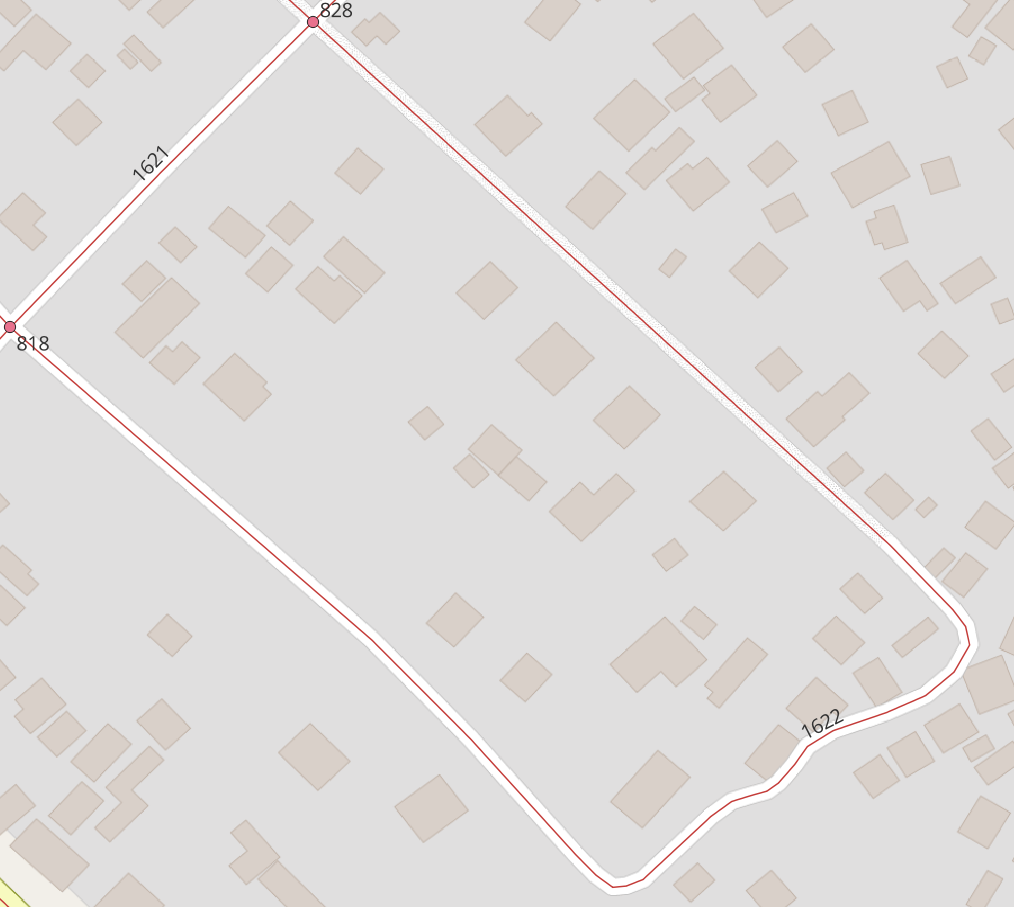